### Helper functions

In [1]:
import pandas as pd
from IPython.display import display
import os
import json

os.chdir('..')

In [3]:
from src.evaluation_entry import EvaluationEntry

project_name = 'classeval' # project name


## Helper functions

In [4]:
def get_initial_eval_entry_csv(project_name):
    eval_entries = EvaluationEntry.load_all("initial", project_name)
    data = []

    for eval_entry in eval_entries:
        eval_entry_data = eval_entry.get_eval_entry_csv()
        data.append(eval_entry_data)
    
    init_dfs = pd.concat(data, ignore_index=True)
    # display(init_dfs)
    return init_dfs

In [5]:
def get_enhanced_eval_data(project, settings, optimised_eval=False):
    eval_entries = EvaluationEntry.load_all("enhanced", project)
    data = []
    for eval_entry in eval_entries:
        if "flag" in eval_entry.identifiers and eval_entry.identifiers["flag"] == "old_1":
            continue
        if settings.get('test_source') and eval_entry.get_test_source() != settings['test_source']:
            continue
        if settings.get('test_selection_mode') and eval_entry.identifiers['test_selection_mode'] != settings['test_selection_mode']:
            continue
        if settings.get('num_test_cases') and eval_entry.identifiers['num_test_cases'] != settings['num_test_cases']:
            continue
        if optimised_eval:
            data.append(eval_entry.get_optimised_eval_entry_csv())
        else:
            data.append(eval_entry.get_eval_entry_csv())
    
    enhanced_dfs = pd.concat(data, ignore_index=True)
    return enhanced_dfs

# Example usage
settings = {
    'test_source': "human_written",
    'test_selection_mode': None,
    'num_test_cases': None
}
enhanced_dfs = get_enhanced_eval_data("human_eval", settings)
display(enhanced_dfs)

,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,passed,passed_after_repair,syntax_errors,syntax_errors_after_repair,...,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities,syntactically_correct,syntactically_correct_after_repair,compilable,compilable_after_repair
0,0/human_written/random_from_all/1,human_written,1,random_from_all,164,1312,0,1021,0,0,...,7,1023,461,45,34,0,164,164,164,164
1,1/human_written/random_from_all/3,human_written,3,random_from_all,164,1403,8,1139,0,0,...,3,1140,461,45,27,0,164,164,164,164
2,2/human_written/random_from_all/5,human_written,5,random_from_all,164,1499,8,1206,0,0,...,5,1208,632,63,31,0,164,164,164,164
3,3/human_written/random_from_class_under_test/1,human_written,1,random_from_class_under_test,164,1545,7,1173,0,0,...,1,1178,641,60,38,0,164,164,164,164
4,4/human_written/random_from_class_under_test/3,human_written,3,random_from_class_under_test,164,1588,0,1250,0,0,...,2,1252,944,91,31,0,164,164,164,164
5,5/human_written/random_from_class_under_test/5,human_written,5,random_from_class_under_test,164,1602,0,1243,0,0,...,4,1246,744,74,33,0,164,164,164,164
6,6/human_written/problem_similarity/1,human_written,1,problem_similarity,164,1274,0,977,1,0,...,0,977,533,56,33,0,163,164,164,164
7,7/human_written/problem_similarity/3,human_written,3,problem_similarity,164,1468,0,1164,0,0,...,3,1166,358,30,26,0,164,164,164,164
8,8/human_written/problem_similarity/5,human_written,5,problem_similarity,164,1521,6,1235,0,0,...,7,1235,392,33,28,0,164,164,164,164
9,9/human_written/class_similarity_no_definition/1,human_written,1,class_similarity_no_definition,164,1278,0,1004,0,0,...,0,1004,441,52,33,0,164,164,164,164


In [6]:
# Get initial eval entry data
init_dfs = get_initial_eval_entry_csv("human_eval")
display(init_dfs)

,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,passed,passed_after_repair,syntax_errors,syntax_errors_after_repair,...,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities,syntactically_correct,syntactically_correct_after_repair,compilable,compilable_after_repair
0,0/pynguin,pynguin,None,None,164,515,211,210,0,0,...,0,211,1106,185,0,0,164,164,164,164
1,1/chatgpt,chatgpt,None,None,164,1170,0,969,0,0,...,0,969,164,25,25,0,164,164,163,164
2,2/human_written,human_written,None,None,164,1181,1172,1172,0,0,...,2,1175,796,103,12,0,164,164,164,164


## Initial number of examples experiment

### Figure code

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correctness_metrics(df, after_repair=False):
    df = df.copy()
    
    if after_repair:
        df['passed_percentage'] = df['passed_after_repair'] / df['total_tests'] * 100
    else:
        df['passed_percentage'] = df['passed'] / df['total_tests'] * 100
    
    if after_repair:
        df['syntactically_correct_percentage'] = (df['total_classes'] - df['syntax_errors_after_repair']) / df['total_classes'] * 100
    else:
        df['syntactically_correct_percentage'] = (df['total_classes'] - df['syntax_errors']) / df['total_classes'] * 100
    
    if after_repair:
        df['compilable_percentage'] = (df['total_classes'] - df['compilation_errors_after_repair']) / df['total_classes'] * 100
    else:
        df['compilable_percentage'] = (df['total_classes'] - df['compilation_errors']) / df['total_classes'] * 100
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    metrics = ['syntactically_correct_percentage', 'compilable_percentage', 'passed_percentage']
    titles = ['Syntactically Correct Percentage', 'Compilable Percentage', 'Passed Percentage']
    
    for ax, metric, title in zip(axes, metrics, titles):
        # Plot lines for each test source
        sns.lineplot(data=df, x='num_test_cases', y=metric, hue='test_source', 
                     marker='o', ax=ax)
        
        ax.set_title(title)
        ax.set_xlabel('Number of Test Cases')
        ax.set_ylabel('Percentage (%)')
        
        min_val = df[metric].min()
        max_val = df[metric].max()
        padding = (max_val - min_val) * 0.1
        
        y_min = max(0, min_val - padding)
        y_max = min(110, max_val + padding)
        
        if (max_val - min_val) < 5:
            center = (max_val + min_val) / 2
            y_min = max(0, center - 5)
            y_max = min(110, center + 5)
        
        ax.set_ylim(y_min, y_max)
        ax.legend(title='Test Source')
        ax.set_xticks([1, 3, 5])
    
    plt.tight_layout()
    return fig

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_coverage_metrics(df):
    df = df.copy()
    
    # Convert string percentages to float values
    coverage_metrics = ['branch_coverage', 'line_coverage']
    for metric in coverage_metrics:
        df[metric] = df[metric].astype(float)
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    titles = ['Branch Coverage', 'Line Coverage']
    
    for ax, metric, title in zip(axes, coverage_metrics, titles):
        # Plot lines for each test source
        sns.lineplot(data=df, x='num_test_cases', y=metric, hue='test_source', 
                     marker='o', ax=ax)
        
        ax.set_title(title)
        ax.set_xlabel('Number of Test Cases')
        ax.set_ylabel('Percentage (%)')
        
        # Dynamically set y-axis limits with padding
        min_val = df[metric].min()
        max_val = df[metric].max()
        padding = (max_val - min_val) * 0.1
        y_min = max(0, min_val - padding)
        
        if max_val >= 95:
            y_max = min(110, max_val + padding)
        else:
            y_max = min(100, max_val + padding)
        
        if (max_val - min_val) < 5:
            center = (max_val + min_val) / 2
            y_min = max(0, center - 5)
            y_max = min(110 if max_val >= 95 else 100, center + 5)
        
        ax.set_ylim(y_min, y_max)
        
        # Add a light gray line at 100% for reference if we're showing >100%
        if y_max > 100:
            ax.axhline(y=100, color='lightgray', linestyle='--', linewidth=1)
        
        ax.legend(title='Test Source')
        ax.set_xticks([1, 3, 5])
    
    plt.tight_layout()
    return fig


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_code_quality_metrics(df):
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Define metrics and their display names
    metrics = [
        ('cognitive_complexity', 'Cognitive Complexity'),
        ('cyclomatic_complexity', 'Cyclomatic Complexity'),
        ('squale_index', 'Squale Index'),
        ('code_smells', 'Average No of Code Smells per Test Case'),
        ('lines', 'Average No of Lines of Code per Test Case'),
        ('non_comment_lines', 'Average No of Non-comment Lines per Test Case'),
    ]
    
    # Calculate per-test-case averages where applicable
    if 'total_tests' in df.columns:
        df['code_smells'] = df['code_smells'].astype(float) / df['total_tests'].astype(float)
        df['lines'] = df['lines'].astype(float) / df['total_tests'].astype(float)
        df['non_comment_lines'] = df['non_comment_lines'].astype(float) / df['total_tests'].astype(float)

    for (metric, title) in metrics:
        df[metric] = df[metric].astype(float)

    # Create a figure with subplots (2 rows, 3 columns)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Flatten axes for easy iteration
    axes = axes.flatten()
    
    for ax, (metric, title) in zip(axes, metrics):
        # Plot lines for each test source
        sns.lineplot(data=df, x='num_test_cases', y=metric, hue='test_source',
                    marker='o', ax=ax)
        
        ax.set_title(title)
        ax.set_xlabel('Number of Example Test Cases')
        ax.set_ylabel(title)
        
        # Dynamically set y-axis limits with padding
        min_val = df[metric].min()
        max_val = df[metric].max()
        padding = (max_val - min_val) * 0.1  # 10% padding
        
        # Use automatic scaling for y-axis limits
        y_min = max(0, min_val - padding)
        y_max = max_val + padding
        
        ax.set_ylim(y_min, y_max)
        
        ax.legend(title='Test Source')
        ax.set_xticks([1, 3, 5])
    
    plt.tight_layout()
    return fig

### Figures

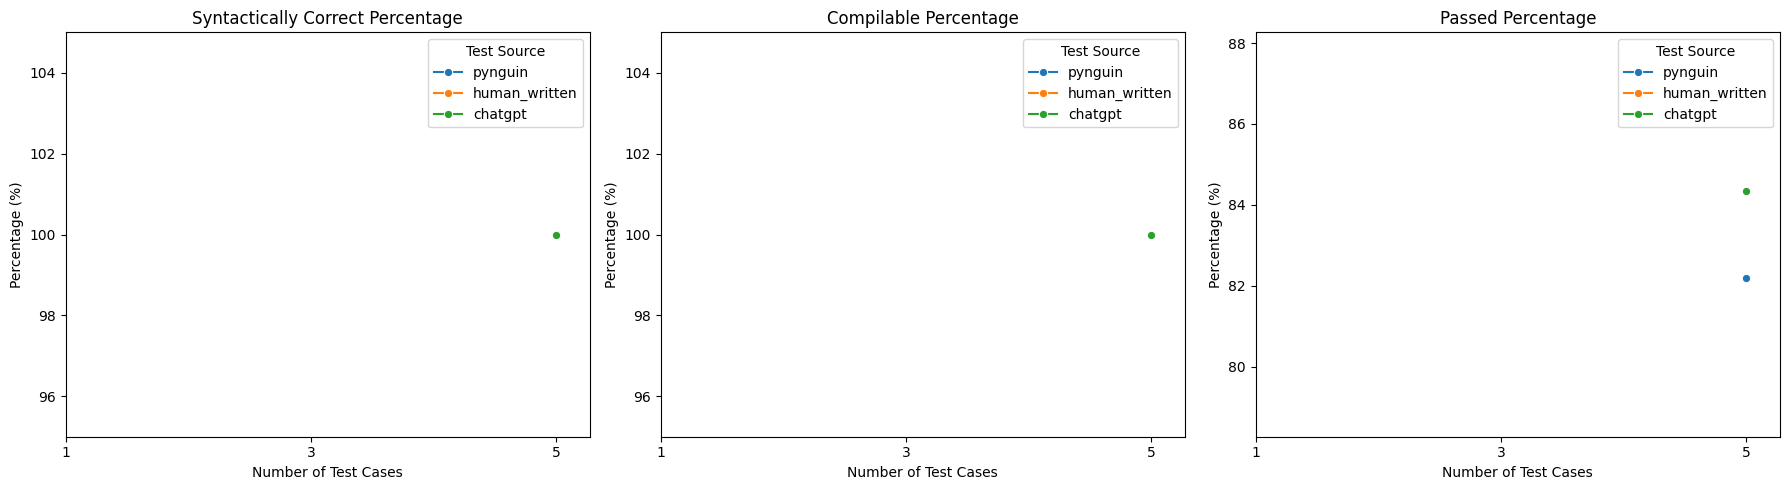

In [10]:
settings = {
    'test_source': None,
    'test_selection_mode': "random_from_all",
    'num_test_cases': None
}
rq0 = get_enhanced_eval_data(project_name, settings)

fig = plot_correctness_metrics(rq0, after_repair=True)
plt.savefig('data/figures/rq0_correctness_for_no_of_test_examples.png', dpi=300, bbox_inches='tight')
plt.show()

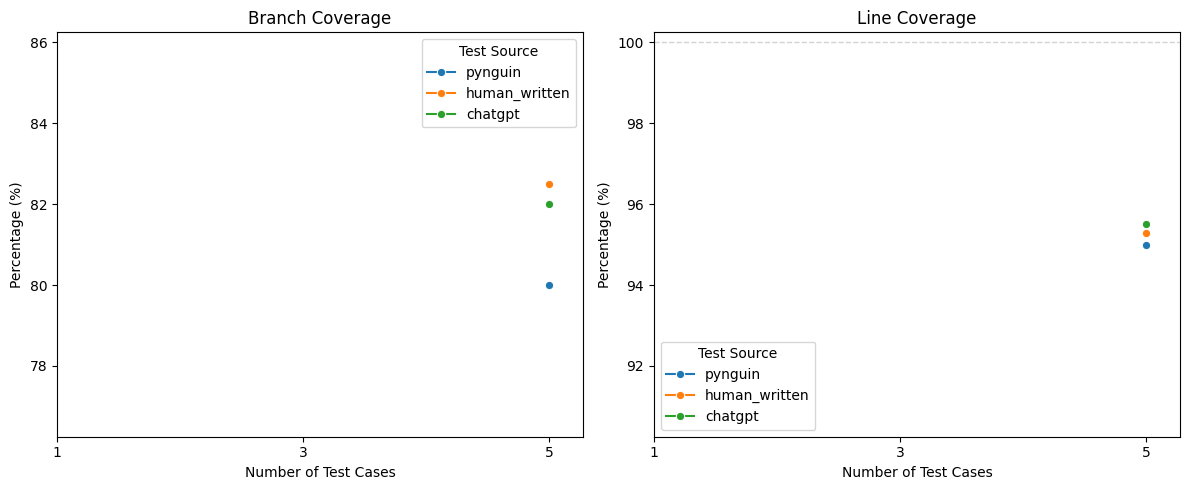

In [11]:
settings = {
    'test_source': None,
    'test_selection_mode': "problem_and_class_similarity",
    'num_test_cases': None
}
enhanced_dfs = get_enhanced_eval_data(project_name, settings)
# display(enhanced_dfs)

fig = plot_coverage_metrics(rq0)
plt.savefig('data/figures/rq0_coverage_for_no_of_test_examples.png', dpi=300, bbox_inches='tight')
plt.show()

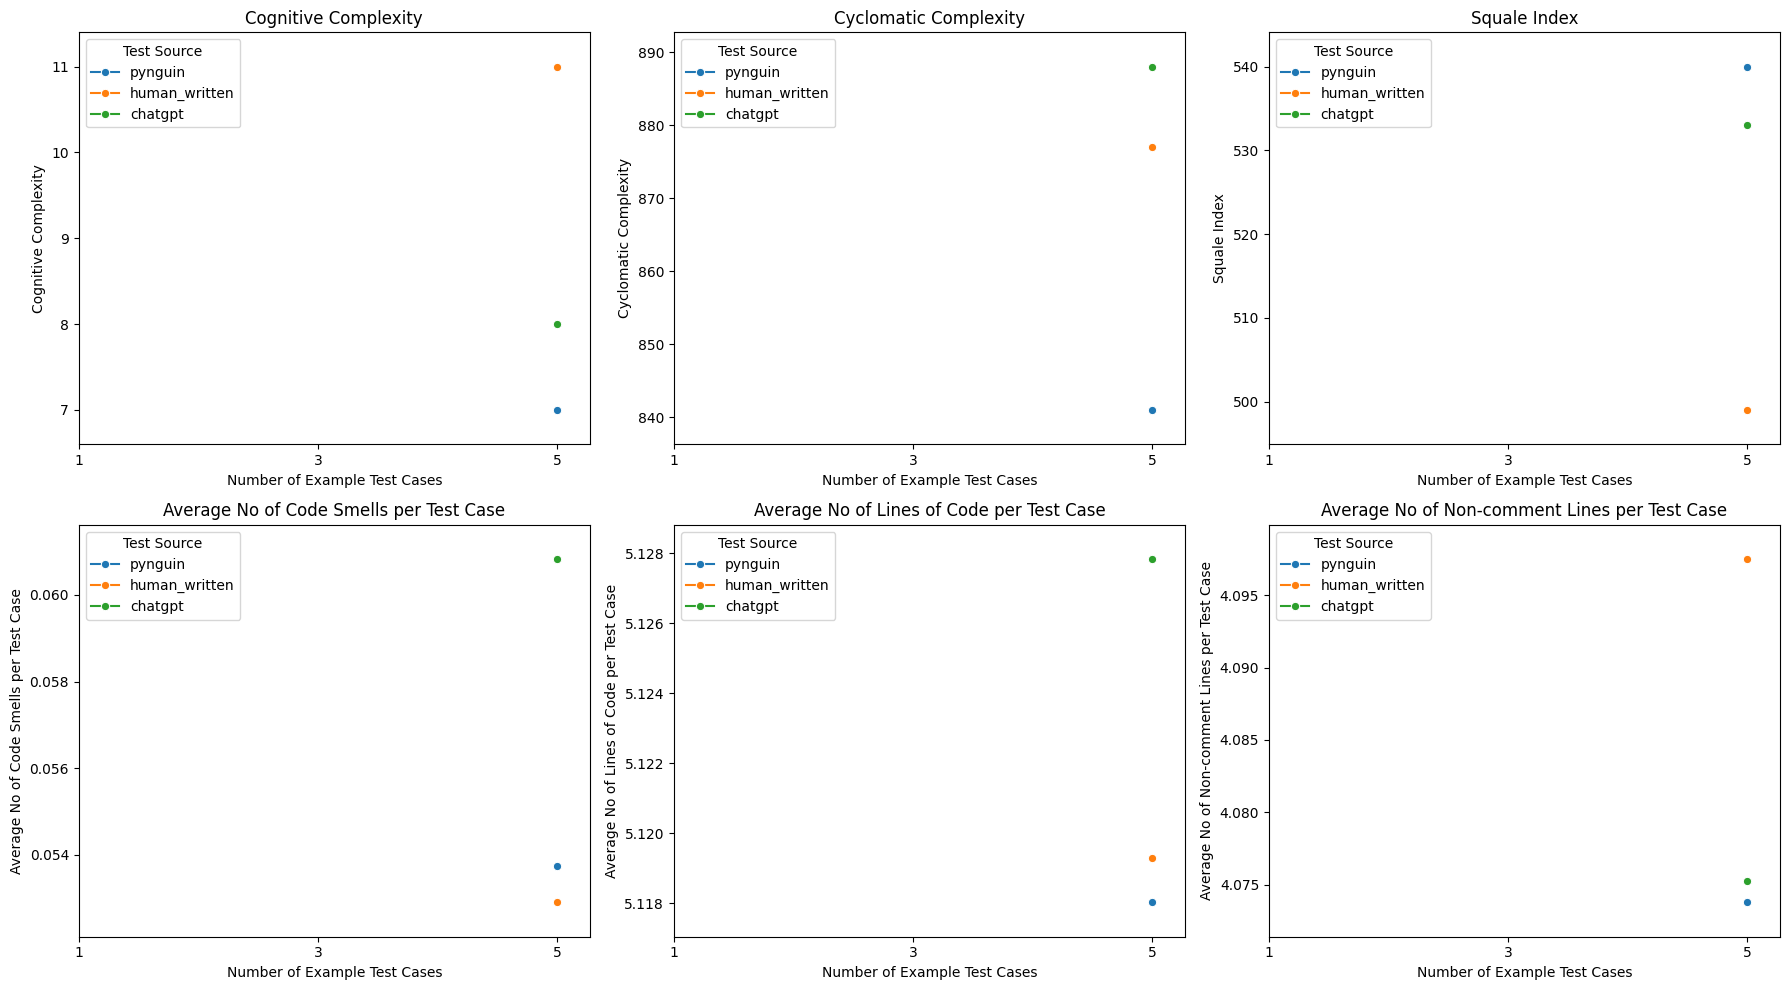

In [12]:
settings = {
    'test_source': None,
    'test_selection_mode': "random_from_all",
    'num_test_cases': None
}
enhanced_dfs = get_enhanced_eval_data(project_name, settings)
# display(enhanced_dfs)

fig = plot_code_quality_metrics(rq0)
plt.savefig('data/figures/rq0_code_quality_for_no_of_test_examples.png', dpi=300, bbox_inches='tight')
plt.show()

## RQ 1.1: Test correctness

### Figure code

In [13]:
def create_correctness_table(df, settings):
    correctness_cols = [
        'total_tests',
        'total_classes',
        'syntactically_correct',
        'syntactically_correct_after_repair',
        'compilable',
        'compilable_after_repair',
        'passed',
        'passed_after_repair',
        # 'no_test_classes_after_repair'
    ]

    # Make the value which is None as id_var
    if settings is not None:
        id_var = next((k for k, v in settings.items() if v is None), None)
    else:
        id_var = 'test_source'
        settings = 'initial'

    # Create correctness table
    melted = df.melt(
        id_vars=[id_var],
        value_vars=correctness_cols,
        var_name='metric',
        value_name='value'
    )
    correctness_table = melted.pivot(index='metric', columns=id_var, values='value').fillna(0).astype(int)
    correctness_table = correctness_table.reindex(correctness_cols)
    # Sort the table by the order of correctness_cols
    

    # Create percentage table
    percentage_table = correctness_table.copy().astype(float)

    for col in percentage_table.columns:
        total_tests = percentage_table.loc['total_tests', col]
        total_classes = percentage_table.loc['total_classes', col]
        for idx in percentage_table.index:
            if idx != 'total_tests' and idx != 'total_classes':
                if idx in ['passed', 'passed_after_repair']:
                    total = total_tests
                else:
                    total = total_classes
                percentage_table.loc[idx, col] = (percentage_table.loc[idx, col] / total * 100) if total > 0 else 0.0
            else:
                percentage_table.loc[idx, col] = None  # No % for total_classes

    # Format values
    percentage_table = percentage_table.applymap(
        lambda x: f"{x:.2f}%" if pd.notna(x) else ""
    )
    correctness_table = correctness_table.astype(str)
    percentage_table.index = [f"{i} (%)" if i != 'total_tests' else '' for i in correctness_table.index]

    # Combine both tables
    combined_table = pd.concat([correctness_table, percentage_table])
    combined_table = combined_table[combined_table.index != '']

    # Display
    print(combined_table)

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_rule_repair_figure(df:pd.DataFrame):
    repair_cols = [col for col in df.columns if col.endswith('_repair_count') and col.startswith('rule_') and col != 'rule_0_repair_count']

    melted_df = df.melt(
        id_vars=['test_source', 'total_classes'],
        value_vars=repair_cols,
        var_name='rule',
        value_name='repair_count'
    )
    # Calculate percentage of classes that underwent each repair rule
    melted_df['pct_classes_repaired'] = (melted_df['repair_count'] / melted_df['total_classes']) * 100

    melted_df['rule'] = melted_df['rule'].str.replace('_repair_count', '').str.replace('rule_', 'Rule ')

    plt.figure(figsize=(10, 5))
    sns.set_theme(style="whitegrid")
    sns.set_context("paper", font_scale=1.7)

    sns.barplot(data=melted_df, x='rule', y='pct_classes_repaired', hue='test_source')

    # plt.yscale('log') # Use log scale to better visualize the differences

    # Adjust layout
    plt.tight_layout()

    plt.ylabel('% of Classes Repaired')
    plt.xlabel('Repair Rule')
    plt.legend(title='Test Source', fontsize=13, title_fontsize=14, loc='upper right', frameon=True, framealpha=0.9)
    plt.tight_layout()
    plt.savefig('data/figures/rq1_1_repair_rule_pct.png', dpi=300, bbox_inches='tight')
    plt.show()

### Figures

In [15]:
settings = {
    'test_source': None,
    'test_selection_mode': "random_from_all",
    'num_test_cases': 5
}
print("ENHANCED DATA")
used_settings = { k:v for k,v in settings.items() if v is not None }
for setting in used_settings:
    print(f"{setting}: {used_settings[setting]}")
rq1_1_dfs = get_enhanced_eval_data(project_name, settings)
display(rq1_1_dfs)
create_correctness_table(rq1_1_dfs, settings=settings)

ENHANCED DATA
test_selection_mode: random_from_all
num_test_cases: 5


,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,passed,passed_after_repair,syntax_errors,syntax_errors_after_repair,...,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities,syntactically_correct,syntactically_correct_after_repair,compilable,compilable_after_repair
0,3/pynguin/random_from_all/5,pynguin,5,random_from_all,99,949,489,780,0,0,...,7,841,540,51,99,0,99,99,97,99
1,9/human_written/random_from_all/5,human_written,5,random_from_all,99,964,193,813,0,0,...,11,877,499,51,102,0,99,99,98,99
2,12/chatgpt/random_from_all/5,chatgpt,5,random_from_all,99,970,181,818,0,0,...,8,888,533,59,95,0,99,99,98,99


test_source                             chatgpt human_written  pynguin
total_tests                                 970           964      949
total_classes                                99            99       99
syntactically_correct                        99            99       99
syntactically_correct_after_repair           99            99       99
compilable                                   98            98       97
compilable_after_repair                      99            99       99
passed                                      181           193      489
passed_after_repair                         818           813      780
total_classes (%)                                                     
syntactically_correct (%)               100.00%       100.00%  100.00%
syntactically_correct_after_repair (%)  100.00%       100.00%  100.00%
compilable (%)                           98.99%        98.99%   97.98%
compilable_after_repair (%)             100.00%       100.00%  100.00%
passed

/var/folders/z7/grqfp40j73xcvr_rkz8n20hm0000gn/T/ipykernel_7163/843863330.py:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  percentage_table = percentage_table.applymap(


REPAIR RULE 


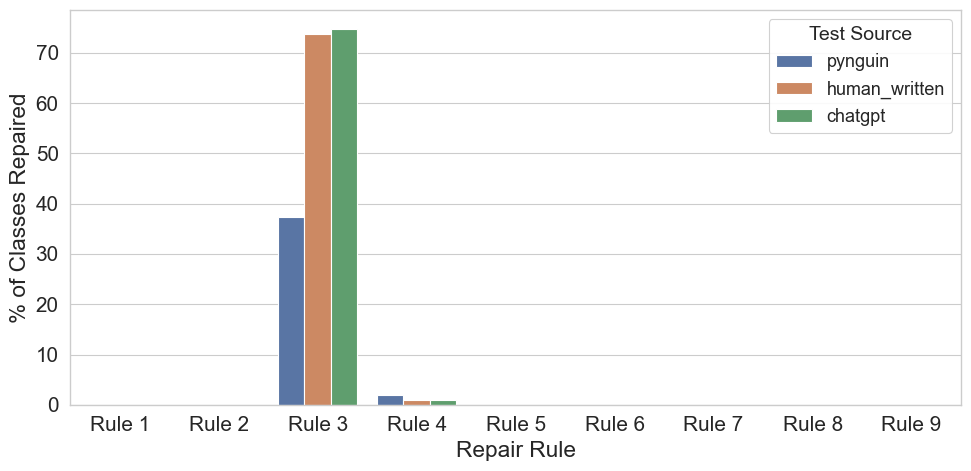

In [16]:
# Display the repair count figure
print("REPAIR RULE ")
create_rule_repair_figure(rq1_1_dfs)

## RQ 1.2: Coverage metrics

### Figure code

In [17]:
# Coverage metrics

def create_coverage_table(df, settings=None):
    coverage_cols = [
        # "coverage",
        "branch_coverage",
        "line_coverage",
        # "lines_to_cover",
        # "uncovered_lines"
    ]
    
    # Make the value which is None as id_var
    if settings is not None:
        id_var = next((k for k, v in settings.items() if v is None), None)
    else:
        id_var = 'test_source'
        settings = 'initial'
    
    # Create correctness table
    melted = df.melt(
        id_vars=[id_var],
        value_vars=coverage_cols,
        var_name='metric',
        value_name='value'
    )
    coverage_table = melted.pivot(index='metric', columns=id_var, values='value').fillna(0)
    coverage_table = coverage_table.reindex(coverage_cols)
    # Sort the table by the order of coverage_cols

    # Format values
    coverage_table = coverage_table.astype(str) + "%"

    # Display
    print(f"INFO: {settings}")
    print(coverage_table)

### Figures

In [18]:
settings = {
    'test_source': None,
    'test_selection_mode': "random_from_all",
    'num_test_cases': 5
}
rq1_2_dfs = get_enhanced_eval_data(project_name, settings)
create_coverage_table(rq1_2_dfs, settings=settings)

INFO: {'test_source': None, 'test_selection_mode': 'random_from_all', 'num_test_cases': 5}
test_source     chatgpt human_written pynguin
metric                                       
branch_coverage   82.0%         82.5%   80.0%
line_coverage     95.5%         95.3%   95.0%


## RQ 1.3: Code quality

### Figure code

In [19]:
# Code quality metrics

def create_code_quality_table(df, settings=None):
    code_quality_cols = [
        "cyclomatic_complexity",
        "cognitive_complexity",
        "squale_index",
        "code_smells",
        # "bugs",
        # "vulnerabilities"
        # "lines",
        "non_comment_lines",
        # "comment_lines",
    ]
    df = df.copy()

    if 'total_tests' in df.columns:
        df['squale_index'] = round(df['squale_index'].astype(float) / df['total_tests'].astype(float), 2)
        df['code_smells'] = round(df['code_smells'].astype(float) / df['total_tests'].astype(float), 2)
        df['non_comment_lines'] = round(df['non_comment_lines'].astype(float) / df['total_tests'].astype(float), 2)

    # Make the value which is None as id_var
    if settings is not None:
        id_var = next((k for k, v in settings.items() if v is None), None)
    else:
        id_var = 'test_source'
        settings = 'initial'
    
    # Create correctness table
    melted = df.melt(
        id_vars=[id_var],
        value_vars=code_quality_cols,
        var_name='metric',
        value_name='value'
    )
    code_quality_table = melted.pivot(index='metric', columns=id_var, values='value').fillna(0)
    code_quality_table = code_quality_table.reindex(code_quality_cols)
    # Sort the table by the order of coverage_cols

    # Format values
    code_quality_table = code_quality_table.astype(str)

    # Display
    print(f"INFO: {settings}")
    print(code_quality_table)

### Figures

In [20]:
settings = {
    'test_source': None,
    'test_selection_mode': "random_from_all",
    'num_test_cases': 5
}
rq1_3_dfs = get_enhanced_eval_data(project_name, settings)
create_code_quality_table(rq1_3_dfs, settings)

INFO: {'test_source': None, 'test_selection_mode': 'random_from_all', 'num_test_cases': 5}
test_source           chatgpt human_written pynguin
metric                                             
cyclomatic_complexity     888           877     841
cognitive_complexity        8            11       7
squale_index             0.55          0.52    0.57
code_smells              0.06          0.05    0.05
non_comment_lines        4.08           4.1    4.07


## RQ 1.4: Test suite optimisation statistics

### Figure code

In [21]:
# Create a table showing the total test numbers

def create_optimisation_test_count_table(df, settings=None, show_percentages=False):
    optimisation_test_count_cols = [
        "total_tests",
        "total_kept_tests",
        "total_removed_tests",
        "total_skipped_tests",
        "total_faulty_tests"
    ]

    display_names = {
        "total_tests": "Total Tests",
        "total_kept_tests": "Kept Tests",
        "total_removed_tests": "Removed Tests",
        "total_skipped_tests": "Skipped Tests",
        "total_faulty_tests": "Faulty Tests"
    }
    
    if settings is not None:
        id_var = next((k for k, v in settings.items() if v is None), None)
    else:
        id_var = 'test_source'
    
    # Create correctness table
    melted = df.melt(
        id_vars=[id_var],
        value_vars=optimisation_test_count_cols,
        var_name='metric',
        value_name='value'
    )
    if show_percentages:
        melted['value'] = melted['value'].astype(float)

    optimisation_test_count_table = melted.pivot(index='metric', columns=id_var, values='value').fillna(0)
    optimisation_test_count_table = optimisation_test_count_table.reindex(optimisation_test_count_cols) # Sort the table by the order of optimisation_test_count_cols
    
    if show_percentages:
        optimisation_test_count_table = optimisation_test_count_table.astype(float)
        # Calculate percentages for all metrics except total_tests
        total_tests = optimisation_test_count_table.loc["total_tests"]
        for metric in optimisation_test_count_cols[1:]:  # Skip total_tests
            optimisation_test_count_table.loc[metric] = (optimisation_test_count_table.loc[metric] / total_tests) * 100
        
        optimisation_test_count_table = optimisation_test_count_table.round(2)
        optimisation_test_count_table = optimisation_test_count_table.astype(str) + "%"
        
        optimisation_test_count_table = optimisation_test_count_table.drop("total_tests")
    else:
        optimisation_test_count_table = optimisation_test_count_table.astype(str)

    optimisation_test_count_table = optimisation_test_count_table.rename(index=display_names)

    # Display
    print(f"INFO: {settings}")
    print(optimisation_test_count_table)

In [22]:
def create_optimisation_coverage_improvement_table(optimised_df, initial_df):
    # Define the test sources and metrics
    test_sources = ["human_written", "pynguin", "chatgpt"]
    metrics = {
        "branch_coverage": "Branch Coverage",
        "line_coverage": "Line Coverage"
    }
    
    # Initialize the result dictionary
    result_data = []
    
    for metric_col, metric_name in metrics.items():
        # Add initial values row
        initial_row = {"Metric": f"{metric_name} (Initial)"}
        optimized_row = {"Metric": f"{metric_name} (Optimized)"}
        diff_row = {"Metric": f"{metric_name} (Δ)"}
        
        for source in test_sources:
            # Get initial and optimized values
            init_val = float(initial_df[initial_df["test_source"] == source][metric_col].values[0])
            opt_val = float(optimised_df[optimised_df["test_source"] == source][metric_col].values[0])
            
            # Calculate difference
            difference = opt_val - init_val
            
            # Format values
            initial_row[source] = f"{init_val:.1f}%"
            optimized_row[source] = f"{opt_val:.1f}%"
            diff_row[source] = f"{difference:+.1f}%"
        
        # Add rows to results
        result_data.extend([initial_row, optimized_row, diff_row])
    
    # Create DataFrame and set index
    result_df = pd.DataFrame(result_data)
    result_df.set_index("Metric", inplace=True)
    
    return result_df

In [23]:
def create_optimisation_code_quality_improvement_table(optimised_df, initial_df):
    # Define the test sources and metrics
    test_sources = ["human_written", "pynguin", "chatgpt"]
    metrics = {
        "cyclomatic_complexity" : "Cyclomatic Complexity",
        "cognitive_complexity": "Cognitive Complexity",
        "squale_index_avg": "Avg Technical Debt",
        "code_smells_avg": "Avg Code Smells",
        "non_comment_lines_avg": "Avg Non-comment Lines",
    }
    
    # Calculate average values
    for avg_metric in ["squale_index", "code_smells", "non_comment_lines"]:
        optimised_df[avg_metric+"_avg"] = optimised_df[avg_metric].astype(float) / optimised_df["total_tests"].astype(float)
        initial_df[avg_metric+"_avg"] = initial_df[avg_metric].astype(float) / initial_df["total_tests"].astype(float)

    # Initialize the result dictionary
    result_data = []
    
    for metric_col, metric_name in metrics.items():
        # Add initial values row
        initial_row = {"Metric": f"{metric_name} (Initial)"}
        optimized_row = {"Metric": f"{metric_name} (Optimized)"}
        diff_row = {"Metric": f"{metric_name} (Δ)"}
        
        for source in test_sources:
            # Get initial and optimized values
            init_val = float(initial_df[initial_df["test_source"] == source][metric_col].values[0])
            opt_val = float(optimised_df[optimised_df["test_source"] == source][metric_col].values[0])
            
            # Calculate difference
            difference = opt_val - init_val
            
            # Format values
            if metric_col in ["squale_index_avg", "code_smells_avg", "non_comment_lines_avg"]:
                initial_row[source] = f"{init_val:.2f}"
                optimized_row[source] = f"{opt_val:.2f}"
                diff_row[source] = f"{difference:+.2f}"
            else: 
                initial_row[source] = f"{init_val:.0f}"
                optimized_row[source] = f"{opt_val:.0f}"
                diff_row[source] = f"{difference:+.0f}"
        
        # Add rows to results
        result_data.extend([initial_row, optimized_row, diff_row])
    
    # Create DataFrame and set index
    result_df = pd.DataFrame(result_data)
    result_df.set_index("Metric", inplace=True)
    
    return result_df

### Figures

In [24]:
settings = {
    'test_source': None,
    'test_selection_mode': "random_from_all",
    'num_test_cases': 5
}
optimised_dfs = get_enhanced_eval_data(project_name, settings, optimised_eval=True)
display(optimised_dfs)

initial_dfs = get_initial_eval_entry_csv(project_name)
display(initial_dfs)

,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,total_kept_tests,total_removed_tests,total_skipped_tests,total_faulty_tests,...,execution_time,lines,non_comment_lines,comment_lines,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities
0,3/pynguin/random_from_all/5,pynguin,5,random_from_all,99,780,182,118,71,409,...,7.26,5002,3935,226,3,414,1076,195,20,0
1,9/human_written/random_from_all/5,human_written,5,random_from_all,99,814,20,46,583,165,...,17.46,15766,12598,98,215,2338,4438,639,237,0
2,12/chatgpt/random_from_all/5,chatgpt,5,random_from_all,99,819,40,329,297,153,...,6.70,4249,3379,95,10,754,431,45,74,0


,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,passed,passed_after_repair,syntax_errors,syntax_errors_after_repair,...,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities,syntactically_correct,syntactically_correct_after_repair,compilable,compilable_after_repair
0,0/human_written,human_written,None,None,99,2151,6,2036,0,0,...,215,2318,4406,636,236,0,99,99,99,99
1,1/pynguin,pynguin,None,None,99,666,229,229,0,0,...,0,229,992,188,0,0,99,99,99,99
2,2/chatgpt,chatgpt,None,None,99,731,0,633,1,0,...,9,713,408,43,69,0,98,99,51,98


In [25]:
data = optimised_dfs.copy()
# display(data)
create_optimisation_test_count_table(data, settings=settings)


INFO: {'test_source': None, 'test_selection_mode': 'random_from_all', 'num_test_cases': 5}
test_source   chatgpt human_written pynguin
metric                                     
Total Tests       819           814     780
Kept Tests         40            20     182
Removed Tests     329            46     118
Skipped Tests     297           583      71
Faulty Tests      153           165     409


In [26]:
data = optimised_dfs.copy()
# display(data)
create_optimisation_test_count_table(data, settings=settings, show_percentages=True)


INFO: {'test_source': None, 'test_selection_mode': 'random_from_all', 'num_test_cases': 5}
test_source   chatgpt human_written pynguin
metric                                     
Kept Tests      4.88%         2.46%  23.33%
Removed Tests  40.17%         5.65%  15.13%
Skipped Tests  36.26%        71.62%    9.1%
Faulty Tests   18.68%        20.27%  52.44%


In [27]:
# Compare the initial and optimised coverage metrics
create_optimisation_coverage_improvement_table(optimised_dfs, initial_dfs)

# TODO: rerun the initial chatgpt eval to get the correct values

,human_written,pynguin,chatgpt
Metric,,,
Branch Coverage (Initial),93.1%,36.8%,76.2%
Branch Coverage (Optimized),93.8%,60.7%,82.4%
Branch Coverage (Δ),+0.7%,+23.9%,+6.2%
Line Coverage (Initial),97.4%,68.2%,93.2%
Line Coverage (Optimized),97.5%,83.1%,95.2%
Line Coverage (Δ),+0.1%,+14.9%,+2.0%


In [28]:
create_optimisation_code_quality_improvement_table(optimised_dfs, initial_dfs)

,human_written,pynguin,chatgpt
Metric,,,
Cyclomatic Complexity (Initial),2318,229,713
Cyclomatic Complexity (Optimized),2338,414,754
Cyclomatic Complexity (Δ),+20,+185,+41
Cognitive Complexity (Initial),215,0,9
Cognitive Complexity (Optimized),215,3,10
Cognitive Complexity (Δ),+0,+3,+1
Avg Technical Debt (Initial),2.05,1.49,0.56
Avg Technical Debt (Optimized),5.45,1.38,0.53
Avg Technical Debt (Δ),+3.40,-0.11,-0.03


## RQ 2.1: Selection technique test correctness

### Figure code

In [29]:
def create_correctness_table_selection_techniques(df):
    correctness_cols = [
        'total_tests',
        'total_classes',
        'syntactically_correct',
        'syntactically_correct_after_repair',
        'compilable',
        'compilable_after_repair',
        'passed',
        'passed_after_repair',
        # 'no_test_classes_after_repair'
    ]

    # Create correctness table
    melted = df.melt(
        id_vars=['test_source', 'test_selection_mode'],
        value_vars=correctness_cols,
        var_name='metric',
        value_name='value'
    )
    correctness_table = melted.pivot_table(index='metric', columns=['test_source', 'test_selection_mode'], values='value', aggfunc='first').fillna(0).astype(int)
    correctness_table = correctness_table.reindex(correctness_cols)
    # Sort the table by the order of correctness_cols
    

    # Create percentage table
    percentage_table = correctness_table.copy().astype(float)

    for col in percentage_table.columns:
        total_tests = percentage_table.loc['total_tests', col]
        total_classes = percentage_table.loc['total_classes', col]
        for idx in percentage_table.index:
            if idx != 'total_tests' and idx != 'total_classes':
                if idx in ['passed', 'passed_after_repair']:
                    total = total_tests
                else:
                    total = total_classes
                percentage_table.loc[idx, col] = (percentage_table.loc[idx, col] / total * 100) if total > 0 else 0.0
            else:
                percentage_table.loc[idx, col] = None  # No % for total_classes

    # Format values
    percentage_table = percentage_table.applymap(
        lambda x: f"{x:.2f}%" if pd.notna(x) else ""
    )
    correctness_table = correctness_table.astype(str)
    percentage_table.index = [f"{i} (%)" if i != 'total_tests' else '' for i in correctness_table.index]

    # Combine both tables
    combined_table = pd.concat([correctness_table, percentage_table])
    combined_table = combined_table[combined_table.index != '']

    # Display
    display(combined_table) 

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

def create_rule_repair_figure_selection_techniques(df:pd.DataFrame):
    repair_cols = [col for col in df.columns if col.endswith('_repair_count') and col.startswith('rule_') and col != 'rule_0_repair_count']

    test_selection_mode_display_names = {
        "random_from_all": "Random from All",
        "random_from_class_under_test": "Random from Class Under Test",
        "problem_similarity": "Problem Definition Similarity",
        "class_similarity_no_definition": "Source Code Similarity",
        "class_similarity_with_definition": "Source Code with Definition Comment Similarity ",
        "problem_and_class_similarity": "Problem Definition and Source Code Similarity",
    }

    melted_df = df.melt(
        id_vars=['test_source', 'test_selection_mode', 'total_classes'],
        value_vars=repair_cols,
        var_name='rule',
        value_name='repair_count'
    )

    # Calculate percentage of classes that underwent each repair rule
    melted_df['pct_classes_repaired'] = (melted_df['repair_count'] / melted_df['total_classes']) * 100
    melted_df['rule'] = melted_df['rule'].str.replace('_repair_count', '').str.replace('rule_', 'Rule ')

    selection_mode = melted_df['test_selection_mode'].unique()

    fix, axes = plt.subplots(2,3, figsize=(14, 8))
    sns.set_theme(style="whitegrid")
    sns.set_context("paper", font_scale=1.4)
    
    axes = axes.flatten()
    for i,mode in enumerate(selection_mode):
        ax = axes[i]
        mode_df = melted_df[melted_df['test_selection_mode'] == mode]

        sns.barplot(data=mode_df, x='rule', y='pct_classes_repaired', hue='test_source', ax=ax)

        ax.set_title(f"{test_selection_mode_display_names[mode]}")
        ax.set_ylabel('% of Classes Repaired' if i % 3 == 0 else '')
        ax.set_xlabel('Repair Rule')
        ax.legend(title='Test Source', fontsize=12, title_fontsize=14, loc='upper right', frameon=True, framealpha=0.8)
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylim(0, 100)

        # Add value labels on top of bars
        for p in ax.patches:
            height = p.get_height()
            if height > 0:  # Only label bars with height > 0
                if height > 25:
                    ax.text(
                        p.get_x() + p.get_width() / 1.5,
                        height / 2,
                        f'{height:.1f}%',
                        ha='center',
                        va='center',
                        color='white',
                        rotation=90,
                        fontsize=8,
                    )
                else:
                    height_pos = height + 0.5
                    # if mode in ['class_similarity_no_definition', 'class_similarity_with_definition'] and rule == 'Rule 1' and test_source == 'pynguin':
                    #     height_pos += 4
                    ax.text(
                        p.get_x() + p.get_width() / 2.,
                        height_pos,
                        f'{height:.1f}%',
                        ha='center',
                        va='bottom',
                        fontsize=8
                    )

    plt.tight_layout()
    plt.savefig('data/figures/rq2_1_multimodal_repair_rule_pct.png', dpi=300, bbox_inches='tight')
    plt.show()

In [31]:
# Chart

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def create_code_coverage_chart(df, settings=None, display_variable="coverage"):
    # Validate input
    if settings is None:
        settings = {'test_source': None, 'test_selection_mode': None, 'num_test_cases': 1}
    
    # Identify varying and fixed variables
    varying_vars = [k for k, v in settings.items() if v is None]
    fixed_vars = {k: v for k, v in settings.items() if v is not None}
    fixed_var = next((k for k, v in settings.items() if v is not None), None)
    
    if len(varying_vars) != 2:
        raise ValueError("Exactly 2 variables must vary (be set to `None`).")

    # Filter data based on fixed settings
    mask = pd.Series(True, index=df.index)
    for key, val in fixed_vars.items():
        mask &= (df[key] == val)
    df_filtered = df[mask]

    # Ensure display_variable exists in the DataFrame
    if display_variable not in df_filtered.columns:
        raise ValueError(f"Column {display_variable} not found in the DataFrame.")
    
    # Convert display_variable to numeric, coercing errors (e.g., strings) to NaN
    df_filtered[display_variable] = pd.to_numeric(
        df_filtered[display_variable],
        errors='coerce'  # Convert non-numeric to NaN
    )
    
    # Drop rows where 'coverage' is NaN (if any conversion failed)
    df_filtered = df_filtered.dropna(subset=[display_variable]) 

    # Pivot data for plotting
    pivot_df = df_filtered.pivot(
        index=varying_vars[0],
        columns=varying_vars[1],
        values=display_variable
    ).fillna(0)

    # Plotting
    label = display_variable.replace("_", " ").capitalize()
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': label})
    plt.title(f"{label} for  {fixed_var.replace('_', ' ').capitalize()} = {fixed_vars[fixed_var]}")
    plt.xlabel(varying_vars[1])
    plt.ylabel(varying_vars[0])
    plt.show()

### Figures

In [32]:
settings = {
    'test_source': None,
    'test_selection_mode': None,
    'num_test_cases': 5  # Vary two variables
}
rq2_1_data = get_enhanced_eval_data(project_name, settings)
display(rq2_1_data)

,eval_id,test_source,num_test_cases,test_selection_mode,total_classes,total_tests,passed,passed_after_repair,syntax_errors,syntax_errors_after_repair,...,cognitive_complexity,cyclomatic_complexity,squale_index,code_smells,bugs,vulnerabilities,syntactically_correct,syntactically_correct_after_repair,compilable,compilable_after_repair
0,0/human_written/random_from_class_under_test/5,human_written,5,random_from_class_under_test,99,1073,85,849,0,0,...,22,899,709,180,75,0,99,99,99,99
1,1/human_written/problem_similarity/5,human_written,5,problem_similarity,99,988,194,830,0,0,...,12,900,534,53,100,0,99,99,97,99
2,2/human_written/problem_and_class_similarity/5,human_written,5,problem_and_class_similarity,99,993,185,840,0,0,...,13,911,489,53,94,0,99,99,97,99
3,3/pynguin/random_from_all/5,pynguin,5,random_from_all,99,949,489,780,0,0,...,7,841,540,51,99,0,99,99,97,99
4,4/pynguin/random_from_class_under_test/5,pynguin,5,random_from_class_under_test,99,1029,592,838,1,1,...,9,903,565,54,108,0,98,98,98,99
5,5/pynguin/problem_similarity/5,pynguin,5,problem_similarity,99,937,542,779,1,0,...,17,847,533,50,96,0,98,99,98,99
6,6/pynguin/class_similarity_no_definition/5,pynguin,5,class_similarity_no_definition,99,960,490,798,0,0,...,17,870,461,44,91,0,99,99,99,99
7,7/pynguin/class_similarity_with_definition/5,pynguin,5,class_similarity_with_definition,99,987,496,823,2,0,...,13,888,504,49,101,0,97,99,98,99
8,8/pynguin/problem_and_class_similarity/5,pynguin,5,problem_and_class_similarity,99,945,579,794,1,0,...,8,855,604,53,101,0,98,99,99,99
9,9/human_written/random_from_all/5,human_written,5,random_from_all,99,964,193,813,0,0,...,11,877,499,51,102,0,99,99,98,99


In [33]:

create_correctness_table_selection_techniques(rq2_1_data)
# create_correctness_table(chatgpt_data, settings=settings)

/var/folders/z7/grqfp40j73xcvr_rkz8n20hm0000gn/T/ipykernel_7163/1913381599.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  percentage_table = percentage_table.applymap(


test_source                                                   chatgpt  \
test_selection_mode                    class_similarity_no_definition   
total_tests                                                       965   
total_classes                                                      99   
syntactically_correct                                              98   
syntactically_correct_after_repair                                 99   
compilable                                                         97   
compilable_after_repair                                            99   
passed                                                            171   
passed_after_repair                                               805   
total_classes (%)                                                       
syntactically_correct (%)                                      98.99%   
syntactically_correct_after_repair (%)                        100.00%   
compilable (%)                                                 97.98%   
compilable_after_repair (%)                                   100.00%   
passed (%)                                                     17.72%   
passed_after_repair (%)                                        83.42%   

test_source                                                              \
test_selection_mode                    class_similarity_with_definition   
total_tests                                                         988   
total_classes                                                        99   
syntactically_correct                                                99   
syntactically_correct_after_repair                                   99   
compilable                                                           98   
compilable_after_repair                                              99   
passed                                                              189   
passed_after_repair                                                 821   
total_classes (%)                                                         
syntactically_correct (%)                                       100.00%   
syntactically_correct_after_repair (%)                          100.00%   
compilable (%)                                                   98.99%   
compilable_after_repair (%)                                     100.00%   
passed (%)                                                       19.13%   
passed_after_repair (%)                                          83.10%   

test_source                                                          \
test_selection_mode                    problem_and_class_similarity   
total_tests                                                     977   
total_classes                                                    99   
syntactically_correct                                            99   
syntactically_correct_after_repair                               99   
compilable                                                       97   
compilable_after_repair                                          99   
passed                                                          175   
passed_after_repair                                             823   
total_classes (%)                                                     
syntactically_correct (%)                                   100.00%   
syntactically_correct_after_repair (%)                      100.00%   
compilable (%)                                               97.98%   
compilable_after_repair (%)                                 100.00%   
passed (%)                                                   17.91%   
passed_after_repair (%)                                      84.24%   

test_source                                                                \
test_selection_mode                    problem_similarity random_from_all   
total_tests                                           988             970   
total_classes                              

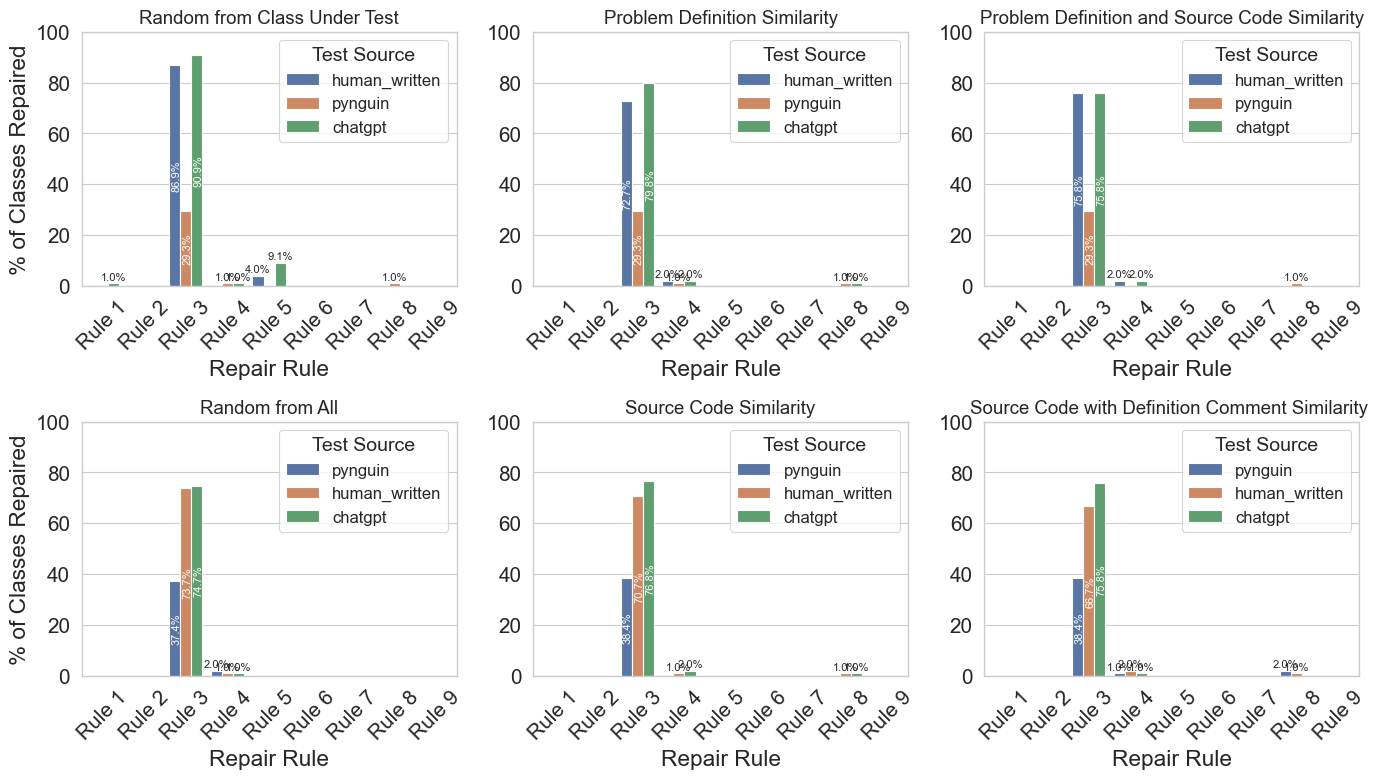

In [34]:
create_rule_repair_figure_selection_techniques(rq2_1_data)

# Shift the values up if overlapping

In [35]:
# create_code_coverage_chart(rq2_1_data, settings=settings, display_variable="branch_coverage")
# create_code_coverage_chart(rq2_1_data, settings, "line_coverage")

## RQ2.2 - Coverage metrics

### Figure code

In [36]:
def create_coverage_table_selection_techniques(df):
    coverage_cols = [
        "branch_coverage",
        "line_coverage"
    ]

    # Create coverage table
    melted = df.melt(
        id_vars=['test_source', 'test_selection_mode'],
        value_vars=coverage_cols,
        var_name='metric',
        value_name='value'
    )
    
    # Pivot table with multi-index columns
    coverage_table = melted.pivot_table(
        index='metric',
        columns=['test_source', 'test_selection_mode'],
        values='value',
        aggfunc='first'
    ).fillna(0)
    
    coverage_table = coverage_table.applymap(lambda x: f"{x}")
    coverage_table.index = [f"{metric} (%)" for metric in coverage_table.index]

    
    # Display
    display(coverage_table)

### Figures

In [37]:
settings = {
    'test_source': None,
    'test_selection_mode': None,
    'num_test_cases': 5
}
rq2_2_data = get_enhanced_eval_data(project_name, settings)
create_coverage_table_selection_techniques(rq2_2_data)

/var/folders/z7/grqfp40j73xcvr_rkz8n20hm0000gn/T/ipykernel_7163/1743355439.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  coverage_table = coverage_table.applymap(lambda x: f"{x}")


test_source                                chatgpt  \
test_selection_mode class_similarity_no_definition   
branch_coverage (%)                           79.6   
line_coverage (%)                             94.8   

test_source                                           \
test_selection_mode class_similarity_with_definition   
branch_coverage (%)                             80.7   
line_coverage (%)                               95.4   

test_source                                                          \
test_selection_mode problem_and_class_similarity problem_similarity   
branch_coverage (%)                         83.6               82.0   
line_coverage (%)                           95.7               95.6   

test_source                                                       \
test_selection_mode random_from_all random_from_class_under_test   
branch_coverage (%)            82.0                         68.2   
line_coverage (%)              95.5                         88.4   

test_source                          human_written  \
test_selection_mode class_similarity_no_definition   
branch_coverage (%)                           82.3   
line_coverage (%)                             94.9   

test_source                                           \
test_selection_mode class_similarity_with_definition   
branch_coverage (%)                             81.3   
line_coverage (%)                               94.8   

test_source                                                          \
test_selection_mode problem_and_class_similarity problem_similarity   
branch_coverage (%)                         85.3               83.1   
line_coverage (%)                           96.8               95.8   

test_source                                                       \
test_selection_mode random_from_all random_from_class_under_test   
branch_coverage (%)            82.5                         73.9   
line_coverage (%)              95.3                         94.0   

test_source                                pynguin  \
test_selection_mode class_similarity_no_definition   
branch_coverage (%)                           82.3   
line_coverage (%)                             95.3   

test_source                                           \
test_selection_mode class_similarity_with_definition   
branch_coverage (%)                             81.8   
line_coverage (%)                               96.1   

test_source                                                          \
test_selection_mode problem_and_class_similarity problem_similarity   
branch_coverage (%)                         82.0               77.2   
line_coverage (%)                           95.2               93.4   

test_source                                                       
test_selection_mode random_from_all random_from_class_under_test  
branch_coverage (%)            80.0                         81.7  
line_coverage (%)              95.0                         95.8

## RQ2.3 - Code quality metrics

### Figure code

In [38]:
# Code quality metrics

def create_code_quality_table_selection_techniques(df, settings=None):
    code_quality_cols = [
        "cyclomatic_complexity",
        "cognitive_complexity",
        "squale_index",
        "code_smells",
        # "bugs",
        # "vulnerabilities"
        # "lines",
        "non_comment_lines",
        # "comment_lines",
    ]
    df = df.copy()

    if 'total_tests' in df.columns:
        df['squale_index'] = round(df['squale_index'].astype(float) / df['total_tests'].astype(float), 2)
        df['code_smells'] = round(df['code_smells'].astype(float) / df['total_tests'].astype(float), 2)
        df['non_comment_lines'] = round(df['non_comment_lines'].astype(float) / df['total_tests'].astype(float), 2)

    # Make the value which is None as id_var
    if settings is not None:
        id_vars = [k for k, v in settings.items() if v is None]
    else:
        id_vars = ['test_source', 'test_selection_mode']
        settings = 'initial'
    
    # Create correctness table
    melted = df.melt(
        id_vars=id_vars,
        value_vars=code_quality_cols,
        var_name='metric',
        value_name='value'
    )
    code_quality_table = melted.pivot(index='metric', columns=id_vars, values='value').fillna(0)
    code_quality_table = code_quality_table.reindex(code_quality_cols)
    # Sort the table by the order of coverage_cols

    # Format values
    code_quality_table = code_quality_table.astype(str)

    # Display
    print(f"INFO: {settings}")
    display(code_quality_table)

### Figures

In [39]:
settings = {
    'test_source': None,
    'test_selection_mode': None,
    'num_test_cases': 5
}
rq2_3_data = get_enhanced_eval_data(project_name, settings)
create_code_quality_table_selection_techniques(rq2_3_data, settings=settings)

INFO: {'test_source': None, 'test_selection_mode': None, 'num_test_cases': 5}


test_source                          human_written                     \
test_selection_mode   random_from_class_under_test problem_similarity   
metric                                                                  
cyclomatic_complexity                          899                900   
cognitive_complexity                            22                 12   
squale_index                                  0.66               0.54   
code_smells                                   0.17               0.05   
non_comment_lines                             4.01               3.81   

test_source                                                pynguin  \
test_selection_mode   problem_and_class_similarity random_from_all   
metric                                                               
cyclomatic_complexity                          911             841   
cognitive_complexity                            13               7   
squale_index                                  0.49            0.57   
code_smells                                   0.05            0.05   
non_comment_lines                             3.87            4.07   

test_source                                                            \
test_selection_mode   random_from_class_under_test problem_similarity   
metric                                                                  
cyclomatic_complexity                          903                847   
cognitive_complexity                             9                 17   
squale_index                                  0.55               0.57   
code_smells                                   0.05               0.05   
non_comment_lines                             4.13               4.22   

test_source                                           \
test_selection_mode   class_similarity_no_definition   
metric                                                 
cyclomatic_complexity                            870   
cognitive_complexity                              17   
squale_index                                    0.48   
code_smells                                     0.05   
non_comment_lines                               4.09   

test_source                                             \
test_selection_mode   class_similarity_with_definition   
metric                                                   
cyclomatic_complexity                              888   
cognitive_complexity                                13   
squale_index                                      0.51   
code_smells                                       0.05   
non_comment_lines                                 4.16   

test_source                                          human_written  \
test_selection_mode   problem_and_class_similarity random_from_all   
metric                                                               
cyclomatic_complexity                          855             877   
cognitive_complexity                             8              11   
squale_index                                  0.64            0.52   
code_smells                                   0.06            0.05   
non_comment_lines                             4.19             4.1   

test_source                                           \
test_selection_mode   class_similarity_no_definition   
metric                                                 
cyclomatic_complexity                            882   
cognitive_complexity                              23   
squale_index                                    0.45   
code_smells                                     0.04   
non_comment_lines                               3.95   

test_source                                                    chatgpt  \
test_selection_mode   class_similarity_with_definition random_from_all   
metric                                                                   
cyclomatic_complexity                              879             888   
cognitive_complexity                             

## RQ2.4 - Coverage improvement test cases

### Figure code

In [40]:
# Create a table showing the total test numbers

def create_optimisation_test_count_table_selection_techniques(df, show_percentages=False):
    optimisation_test_count_cols = [
        "total_tests",
        "total_kept_tests",
        "total_removed_tests",
        "total_skipped_tests",
        # "total_faulty_tests"
    ]

    display_names = {
        "total_tests": "Total Tests",
        "total_kept_tests": "Kept Tests",
        "total_removed_tests": "Removed Tests",
        "total_skipped_tests": "Skipped Tests",
        # "total_faulty_tests": "Faulty Tests"
    }
    
    # Create correctness table
    melted = df.melt(
        id_vars=['test_source', 'test_selection_mode'],
        value_vars=optimisation_test_count_cols,
        var_name='metric',
        value_name='value'
    )
    if show_percentages:
        melted['value'] = melted['value'].astype(float)

    optimisation_test_count_table = melted.pivot_table(index='metric', columns=['test_source', 'test_selection_mode'], values='value', aggfunc='first').fillna(0)
    optimisation_test_count_table = optimisation_test_count_table.reindex(optimisation_test_count_cols) # Sort the table by the order of optimisation_test_count_cols
    
    if show_percentages:
        optimisation_test_count_table = optimisation_test_count_table.astype(float)
        # Calculate percentages for all metrics except total_tests
        total_tests = optimisation_test_count_table.loc["total_tests"]
        for metric in optimisation_test_count_cols[1:]:  # Skip total_tests
            optimisation_test_count_table.loc[metric] = (optimisation_test_count_table.loc[metric] / total_tests) * 100
        
        optimisation_test_count_table = optimisation_test_count_table.round(2)
        optimisation_test_count_table = optimisation_test_count_table.astype(str) + "%"
        
        optimisation_test_count_table = optimisation_test_count_table.drop("total_tests")
    else:
        optimisation_test_count_table = optimisation_test_count_table.astype(str)

    optimisation_test_count_table = optimisation_test_count_table.rename(index=display_names)

    # Display
    # print(f"INFO: {settings}")
    display(optimisation_test_count_table)

In [41]:
def create_optimisation_coverage_improvement_table_selection_techniques(optimised_df, initial_df):
    # Define the test sources and metrics
    test_sources = ["human_written", "pynguin", "chatgpt"]
    metrics = {
        "branch_coverage": "Branch Coverage",
        "line_coverage": "Line Coverage"
    }
    
    optimised_melted = optimised_df.melt(
        id_vars=['test_source', 'test_selection_mode'],
        value_vars=list(metrics.keys()),
        var_name='metric',
        value_name='optimised_value'
    )

    initial_values = initial_df.melt(
        id_vars=['test_source'],
        value_vars=list(metrics.keys()),
        var_name='metric',
        value_name='initial_value'
    )

    merged_df = pd.merge(
        optimised_melted,
        initial_values,
        on=['test_source', 'metric']
    )

    merged_df['difference'] = merged_df['optimised_value'].astype(float) - merged_df['initial_value'].astype(float)

    # Initialize the result dictionary
    result_data = []
    
    result_data = []
    for metric_col, metric_name in metrics.items():
        metric_df = merged_df[merged_df['metric'] == metric_col].copy()
        
        # Create rows for each metric
        initial_row = {'Metric': f"{metric_name} (Initial)"}
        optimised_row = {'Metric': f"{metric_name} (Optimized)"}
        diff_row = {'Metric': f"{metric_name} (Δ)"}
        
        # Pivot to get test_source as columns and test_selection_mode as sub-columns
        for (test_source, selection_mode), group in metric_df.groupby(['test_source', 'test_selection_mode']):
            col_key = (test_source, selection_mode)
            initial_row[col_key] = f"{float(group['initial_value'].values[0]):.1f}%"
            optimised_row[col_key] = f"{float(group['optimised_value'].values[0]):.1f}%"
            diff_row[col_key] = f"{float(group['difference'].values[0]):+.1f}%"
        
        result_data.extend([initial_row, optimised_row, diff_row])
    
    # Create DataFrame and set index
    result_df = pd.DataFrame(result_data)
    result_df.set_index("Metric", inplace=True)
    
    return result_df

In [42]:
def create_complexity_quality_table_selection_techniques(optimised_df, initial_df):
    # Define the metrics
    metrics = {
        "cyclomatic_complexity": "Cyclomatic Complexity",
        "cognitive_complexity": "Cognitive Complexity",
        "squale_index_avg": "Avg Technical Debt",
        "code_smells_avg": "Avg Code Smells",
        "non_comment_lines_avg": "Avg Non-comment Lines"
    }
    
    avg_metrics = ["squale_index", "code_smells", "non_comment_lines"]
    # Calculate average values
    for avg_metric in avg_metrics:
        optimised_df[avg_metric+"_avg"] = optimised_df[avg_metric].astype(float) / optimised_df["total_tests"].astype(float)
        initial_df[avg_metric+"_avg"] = initial_df[avg_metric].astype(float) / initial_df["total_tests"].astype(float)

    # Melt the optimized dataframe to long format
    optimised_melted = optimised_df.melt(
        id_vars=['test_source', 'test_selection_mode'],
        value_vars=list(metrics.keys()),
        var_name='metric',
        value_name='optimised_value'
    )
    
    # Prepare initial values (assuming initial_df has test_source but not test_selection_mode)
    initial_values = initial_df.melt(
        id_vars=['test_source'],
        value_vars=list(metrics.keys()),
        var_name='metric',
        value_name='initial_value'
    )
    
    # Merge with optimized data (cross join to all selection modes)
    merged_df = pd.merge(
        optimised_melted,
        initial_values,
        on=['test_source', 'metric']
    )
    
    merged_df['difference'] = merged_df['optimised_value'].astype(float) - merged_df['initial_value'].astype(float)
    
    result_data = []
    for metric_col, metric_name in metrics.items():
        metric_df = merged_df[merged_df['metric'] == metric_col].copy()
        
        initial_row = {'Metric': f"{metric_name} (Initial)"}
        optimised_row = {'Metric': f"{metric_name} (Optimized)"}
        diff_row = {'Metric': f"{metric_name} (Δ)"}
        
        for (test_source, selection_mode), group in metric_df.groupby(['test_source', 'test_selection_mode']):
            col_key = (test_source, selection_mode)
            
            # Format values differently based on metric type
            if metric_col in ["squale_index_avg", "code_smells_avg", "non_comment_lines_avg"]:
                initial_row[col_key] = f"{float(group['initial_value'].values[0]):.2f}"
                optimised_row[col_key] = f"{float(group['optimised_value'].values[0]):.2f}"
                diff_row[col_key] = f"{float(group['difference'].values[0]):+.2f}"
            else:  # For LOC and other counts
                initial_row[col_key] = f"{int(group['initial_value'].values[0])}"
                optimised_row[col_key] = f"{int(group['optimised_value'].values[0])}"
                diff_row[col_key] = f"{int(group['difference'].values[0]):+d}"
        
        result_data.extend([initial_row, optimised_row, diff_row])
    
    # Create DataFrame with MultiIndex columns
    result_df = pd.DataFrame(result_data)
    result_df.set_index('Metric', inplace=True)
    
    # Create MultiIndex columns
    if not result_df.empty:
        columns = pd.MultiIndex.from_tuples(
            result_df.columns,
            names=['Test Source', 'Selection Mode']
        )
        result_df.columns = columns
    
    return result_df

### Figures

In [43]:
settings = {
    'test_source': None,
    'test_selection_mode': None,
    'num_test_cases': 5
}
rq2_4_data = get_enhanced_eval_data(project_name, settings, optimised_eval=True)

initial_dfs = get_initial_eval_entry_csv(project_name)
display(initial_dfs['squale_index'])

0    4406
1     992
2     408
Name: squale_index, dtype: object

In [44]:
data = rq2_4_data.copy()

create_optimisation_test_count_table_selection_techniques(data)
create_optimisation_test_count_table_selection_techniques(data, show_percentages=True)

test_source                                chatgpt  \
test_selection_mode class_similarity_no_definition   
metric                                               
Total Tests                                    803   
Kept Tests                                      41   
Removed Tests                                  365   
Skipped Tests                                  288   

test_source                                           \
test_selection_mode class_similarity_with_definition   
metric                                                 
Total Tests                                      822   
Kept Tests                                        41   
Removed Tests                                    378   
Skipped Tests                                    300   

test_source                                                          \
test_selection_mode problem_and_class_similarity problem_similarity   
metric                                                                
Total Tests                                  823                838   
Kept Tests                                    56                 36   
Removed Tests                                328                314   
Skipped Tests                                309                258   

test_source                                                       \
test_selection_mode random_from_all random_from_class_under_test   
metric                                                             
Total Tests                     819                          665   
Kept Tests                       40                           54   
Removed Tests                   329                          291   
Skipped Tests                   297                          267   

test_source                          human_written  \
test_selection_mode class_similarity_no_definition   
metric                                               
Total Tests                                    807   
Kept Tests                                      24   
Removed Tests                                   42   
Skipped Tests                                  623   

test_source                                           \
test_selection_mode class_similarity_with_definition   
metric                                                 
Total Tests                                      818   
Kept Tests                                        27   
Removed Tests                                     55   
Skipped Tests                                    603   

test_source                                                          \
test_selection_mode problem_and_class_similarity problem_similarity   
metric                                                                
Total Tests                                  840                830   
Kept Tests                                    19                 26   
Removed Tests                                 49                 36   
Skipped Tests                                597                628   

test_source                                                       \
test_selection_mode random_from_all random_from_class_under_test   
metric                                                             
Total Tests                     814                          849   
Kept Tests                       20                           29   
Removed Tests                    46                           71   
Skipped Tests                   583                          659   

test_source                                pynguin  \
test_selection_mode class_similarity_no_definition   
metric                                               
Total Tests                                    798   
Kept Tests                                     176   
Removed Tests                                  101   
Skipped Tests                                   75   

test_source                                           \
test_selection_mode class_similarity_with_definition   
metric         

test_source                                chatgpt  \
test_selection_mode class_similarity_no_definition   
metric                                               
Kept Tests                                   5.11%   
Removed Tests                               45.45%   
Skipped Tests                               35.87%   

test_source                                           \
test_selection_mode class_similarity_with_definition   
metric                                                 
Kept Tests                                     4.99%   
Removed Tests                                 45.99%   
Skipped Tests                                  36.5%   

test_source                                                          \
test_selection_mode problem_and_class_similarity problem_similarity   
metric                                                                
Kept Tests                                  6.8%               4.3%   
Removed Tests                             39.85%             37.47%   
Skipped Tests                             37.55%             30.79%   

test_source                                                       \
test_selection_mode random_from_all random_from_class_under_test   
metric                                                             
Kept Tests                    4.88%                        8.12%   
Removed Tests                40.17%                       43.76%   
Skipped Tests                36.26%                       40.15%   

test_source                          human_written  \
test_selection_mode class_similarity_no_definition   
metric                                               
Kept Tests                                   2.97%   
Removed Tests                                 5.2%   
Skipped Tests                                77.2%   

test_source                                           \
test_selection_mode class_similarity_with_definition   
metric                                                 
Kept Tests                                      3.3%   
Removed Tests                                  6.72%   
Skipped Tests                                 73.72%   

test_source                                                          \
test_selection_mode problem_and_class_similarity problem_similarity   
metric                                                                
Kept Tests                                 2.26%              3.13%   
Removed Tests                              5.83%              4.34%   
Skipped Tests                             71.07%             75.66%   

test_source                                                       \
test_selection_mode random_from_all random_from_class_under_test   
metric                                                             
Kept Tests                    2.46%                        3.42%   
Removed Tests                 5.65%                        8.36%   
Skipped Tests                71.62%                       77.62%   

test_source                                pynguin  \
test_selection_mode class_similarity_no_definition   
metric                                               
Kept Tests                                  22.06%   
Removed Tests                               12.66%   
Skipped Tests                                 9.4%   

test_source                                           \
test_selection_mode class_similarity_with_definition   
metric                                                 
Kept Tests                                    22.42%   
Removed Tests                                 17.45%   
Skipped Tests                                   8.0%   

test_source                                                          \
test_selection_mode problem_and_class_similarity problem_similarity   
metric                                                                
Kept Tests                                20.88%             22.82%   
Removed Tests                             14.97%          

In [45]:
# Compare the initial and optimised coverage metrics
data = rq2_4_data.copy()
create_optimisation_coverage_improvement_table_selection_techniques(data, initial_dfs)

,"(chatgpt, class_similarity_no_definition)","(chatgpt, class_similarity_with_definition)","(chatgpt, problem_and_class_similarity)","(chatgpt, problem_similarity)","(chatgpt, random_from_all)","(chatgpt, random_from_class_under_test)","(human_written, class_similarity_no_definition)","(human_written, class_similarity_with_definition)","(human_written, problem_and_class_similarity)","(human_written, problem_similarity)","(human_written, random_from_all)","(human_written, random_from_class_under_test)","(pynguin, class_similarity_no_definition)","(pynguin, class_similarity_with_definition)","(pynguin, problem_and_class_similarity)","(pynguin, problem_similarity)","(pynguin, random_from_all)","(pynguin, random_from_class_under_test)"
Metric,,,,,,,,,,,,,,,,,,
Branch Coverage (Initial),76.2%,76.2%,76.2%,76.2%,76.2%,76.2%,93.1%,93.1%,93.1%,93.1%,93.1%,93.1%,36.8%,36.8%,36.8%,36.8%,36.8%,36.8%
Branch Coverage (Optimized),82.3%,81.7%,84.2%,0.0%,82.4%,82.3%,94.3%,94.1%,93.9%,94.3%,93.8%,93.8%,60.5%,62.3%,59.7%,61.6%,60.7%,60.4%
Branch Coverage (Δ),+6.1%,+5.5%,+8.0%,-76.2%,+6.2%,+6.1%,+1.2%,+1.0%,+0.8%,+1.2%,+0.7%,+0.7%,+23.7%,+25.5%,+22.9%,+24.8%,+23.9%,+23.6%
Line Coverage (Initial),93.2%,93.2%,93.2%,93.2%,93.2%,93.2%,97.4%,97.4%,97.4%,97.4%,97.4%,97.4%,68.2%,68.2%,68.2%,68.2%,68.2%,68.2%
Line Coverage (Optimized),95.0%,95.0%,95.4%,28.1%,95.2%,95.3%,97.5%,97.5%,97.5%,97.5%,97.5%,97.5%,82.5%,84.0%,82.3%,83.2%,83.1%,82.2%
Line Coverage (Δ),+1.8%,+1.8%,+2.2%,-65.1%,+2.0%,+2.1%,+0.1%,+0.1%,+0.1%,+0.1%,+0.1%,+0.1%,+14.3%,+15.8%,+14.1%,+15.0%,+14.9%,+14.0%


In [46]:
data = rq2_4_data.copy()
create_complexity_quality_table_selection_techniques(data, initial_dfs)

Test Source                                              chatgpt  \
Selection Mode                    class_similarity_no_definition   
Metric                                                             
Cyclomatic Complexity (Initial)                              713   
Cyclomatic Complexity (Optimized)                            755   
Cyclomatic Complexity (Δ)                                    +42   
Cognitive Complexity (Initial)                                 9   
Cognitive Complexity (Optimized)                              10   
Cognitive Complexity (Δ)                                      +1   
Avg Technical Debt (Initial)                                0.56   
Avg Technical Debt (Optimized)                              0.54   
Avg Technical Debt (Δ)                                     -0.02   
Avg Code Smells (Initial)                                   0.06   
Avg Code Smells (Optimized)                                 0.06   
Avg Code Smells (Δ)                                        -0.00   
Avg Non-comment Lines (Initial)                             4.38   
Avg Non-comment Lines (Optimized)                           4.20   
Avg Non-comment Lines (Δ)                                  -0.18   

Test Source                                                         \
Selection Mode                    class_similarity_with_definition   
Metric                                                               
Cyclomatic Complexity (Initial)                                713   
Cyclomatic Complexity (Optimized)                              754   
Cyclomatic Complexity (Δ)                                      +41   
Cognitive Complexity (Initial)                                   9   
Cognitive Complexity (Optimized)                                 9   
Cognitive Complexity (Δ)                                        +0   
Avg Technical Debt (Initial)                                  0.56   
Avg Technical Debt (Optimized)                                0.52   
Avg Technical Debt (Δ)                                       -0.04   
Avg Code Smells (Initial)                                     0.06   
Avg Code Smells (Optimized)                                   0.05   
Avg Code Smells (Δ)                                          -0.01   
Avg Non-comment Lines (Initial)                               4.38   
Avg Non-comment Lines (Optimized)                             4.08   
Avg Non-comment Lines (Δ)                                    -0.29   

Test Source                                                     \
Selection Mode                    problem_and_class_similarity   
Metric                                                           
Cyclomatic Complexity (Initial)                            713   
Cyclomatic Complexity (Optimized)                          770   
Cyclomatic Complexity (Δ)                                  +57   
Cognitive Complexity (Initial)                               9   
Cognitive Complexity (Optimized)                            10   
Cognitive Complexity (Δ)                                    +1   
Avg Technical Debt (Initial)                              0.56   
Avg Technical Debt (Optimized)                            0.52   
Avg Technical Debt (Δ)                                   -0.04   
Avg Code Smells (Initial)                                 0.06   
Avg Code Smells (Optimized)                               0.05   
Avg Code Smells (Δ)                                      -0.01   
Avg Non-comment Lines (Initial)                           4.38   
Avg Non-comment Lines (Optimized)                         4.18   
Avg Non-comment Lines (Δ)                                -0.20   

Test Source                                                           \
Selection Mode                    problem_similarity random_from_all   
Metric                                                                 
Cyclomatic Complexity (Initial)                  713             713   
Cyclomatic Complexity (Optimized)    